# Co je to Nanopore sekvenování?

## Jak to funguje?

- Nanopór je maličký otvor v tenké membráně.
- Do otvoru se pustí slabý elektrický proud.
- Když DNA prochází skrz, **každé písmeno DNA (A, T, C, G)** trochu změní proud.
- Tato změna se zaznamenává jako **průbeh signálu**.
- Počítač pak z těchto vln pozná, jaká písmena DNA šla dovnitř.

![DNA/RNA sequencng](https://a.storyblok.com/f/196663/640x360/86b5f57ecd/nanopore-sequencing-animation.gif/m/640x360/filters:format(webp))

Podívej se na krátké video (2 minuty):  
🔗 [Jak funguje nanopórové sekvenování – od Oxford Nanopore](https://www.youtube.com/watch?v=2C9gRz8OTR8)

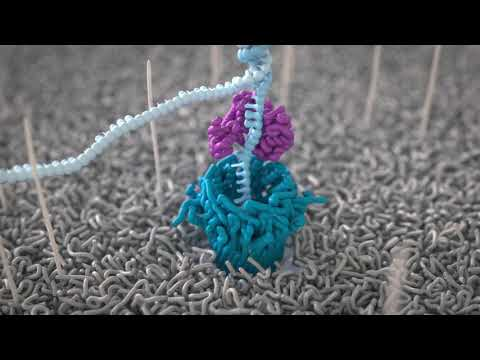

In [14]:
from IPython.display import YouTubeVideo

YouTubeVideo("RcP85JHLmnI", width=800, height=450)

## Podíváme se na skutečný signál

V následujícím grafu uvidíme, jak vypadá **surový signál** ze sekvenátoru.

In [ ]:
import pod5
import matplotlib.pyplot as plt
import numpy as np

# Load a read from a .pod5 file
file_path = "tmp.pod5"  # replace with your actual file path
with pod5.Reader(file_path) as reader:
    read = next(reader.reads())
    signal = read.signal

# Plot the raw signal
plt.figure(figsize=(14, 4))
plt.plot(signal[:300])  # Plot first 300 signal points
plt.title("Nanopore Raw Signal from a Single Read")
plt.xlabel("Time")
plt.ylabel("Current (pA)")
plt.grid(True)
plt.show()

### Otázky na zamyšlení:

**Proč se asi mění signál, když DNA prochází nanopórem?**

<details>
<summary>Odpověď</summary>

Každé písmeno DNA má jiný tvar a jinou velikost, takže ovlivňuje proud jinak. Když DNA prochází nanopórem, ovlivňuje proud iontů (např. Na⁺, Cl⁻), který jím prochází. Různé kombinace písmen DNA (tzv. k-mery) mají různý tvar a elektrické vlastnosti, takže každý z nich mění proud jiným způsobem. Počítač pak z těchto změn pozná, která písmena tam byla.

</details>

**Když dostaneme tento signál, jak bys z něj poznal, jaká písmena jsou v DNA?**

<details>
<summary>Odpověď</summary>
Počítač se to učí z tisíců příkladů pomocí umělé inteligence.

**Zkus si představit:**
Kdybys měl z poslechu hluku určit, co jede po silnici (auto, kolo, autobus), dokážeš to? Nanopór to dělá podobně – rozpoznává, co právě prošlo.
</details>

## Převod signálu na DNA sekvenci – Basecalling

Když molekula DNA prochází nanopórem, zaznamenáváme změny elektrického proudu. Tyto změny tvoří tzv. **surový signál** (anglicky *raw signal*), který je uložen v souborech typu `.pod5`.

Ale abychom zjistili, jaká písmena DNA (A, T, C, G) odpovídají tomuto signálu, potřebujeme **převodník** – ten se nazývá **basecaller**.

## Co dělá basecaller?

- Analyzuje průběh elektrického signálu
- Pomocí umělé inteligence a trénovaných modelů odhadne, jaké nukleotidy procházely nanopórem
- Výsledek je sekvence DNA ve formátu **FASTQ** – tedy:
  - Sekvence (např. `AGGCTTAC...`)
  - Kvalita každého písmena (číslem vyjádřená jistota)

Pro převod použijeme nástroj **Dorado** od Oxford Nanopore Technologies.

V další části nejprve ukážeme basecalling jednotlivých čtení v jednom .pod5 souboru, a poté zpracujeme všechna najednou.

In [ ]:
import subprocess

# set the path to the pod5 file, the model and the output
pod5_file = "/path/to/your/file.pod5"
model_path = "/home/lab33/researchers_night/dna_r10.4.1_e8.2_400bps_sup@v5.0.0/" # backup model dna_r10.4.1_e8.2_400bps_sup@v4.3.0

# TODO test script from ONT PC

# Basecalling a single .pod5 file
print("Basecalling všech čtení v souboru...")
result = subprocess.run(
    f"python3 print_basecalled.py {model_path} {pod5_file}",
    shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
)

Nyní, když víte, jak basecalling funguje, převedeme (basecallujeme) celý běh najednou.

In [1]:
# TODO basecall both healthy control and cancer sample (how many samples?)

In [ ]:
import subprocess

# Set directory containing .pod5 files from the run
pod5_dir = "/path/to/pod5_directory"
model_path = "/home/lab33/researchers_night/dna_r10.4.1_e8.2_400bps_sup@v5.0.0/" # backup model dna_r10.4.1_e8.2_400bps_sup@v4.3.0
output_bam = "basecalled_all_reads.bam"
output_fasta = "basecalled_all_reads.fastq"

# Basecall all .pod5 files in the directory
print("Basecalling všech čtení...")
result = subprocess.run(
    f"dorado basecaller --min-qscore 25 {model_path} {pod5_dir}/*.pod5 > {output_bam}",
    shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
)

In [ ]:
# Convert to FASTQ
print("Převádím výstup na FASTQ...")
subprocess.run(f"samtools fastq {output_bam} > {output_fastq}", shell=True)
print(f"Hotovo. FASTQ výstup uložen do: {output_fastq}")

### Co je ve FASTQ souboru?

Soubor `.fastq` obsahuje výsledky sekvenování – tedy čtení DNA. Každé čtení má 4 řádky:

1. `@` a název čtení
2. Sekvence DNA (např. `ACGTTG...`)
3. `+` jako oddělovač
4. Kvalita jednotlivých bází (čím vyšší znak, tím vyšší jistota)

In [ ]:
!head -n 24 basecalled_reads.fastq

### Zkus si: K jakému organismu patří náš vzorek?

1. Vyber jednu ze sekvencí výše
2. Zkopíruj ji a vlož do nástroje [NCBI BLAST (nucleotide)](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE_TYPE=BlastSearch&PROGRAM=blastn)
3. Stiskni "BLAST"
4. Sleduj, jak databáze najde podobné sekvence a řekne ti, odkud pochází

### Zamysli se

- Jsou některé čtení delší než jiné?
- Všimni si, že některá čtení mají horší kvalitu (nižší znaky ve 4. řádku), použij [tabulku vysvětlující  Phred skóre](https://en.wikipedia.org/wiki/Phred_quality_score)
- Co se asi stane, když pošleme do BLASTu krátké vs. dlouhé čtení?

<details>
<summary>Odpověď</summary>

- Ano, délka čtení se může lišit. Nanopore umožňuje číst velmi dlouhé úseky DNA, ale některá čtení mohou být přerušena dříve.
- Znaky ve 4. řádku ukazují kvalitu každé báze. Nižší znaky znamenají nižší jistotu – mohou být způsobeny šumem v signálu.
- Krátká čtení mají menší šanci najít jednoznačný výsledek v BLASTu – mohou se hodit k více oblastem v různých genomech. Delší čtení jsou často specifičtější a dají lepší nápovědu o původu vzorku.

</details>

## Jak se liší genetická informace zdravého člověka a onkopacienta?

### Co je to karyotyp a proč ho zkoumáme?

Každá lidská buňka (kromě pohlavních buněk) obsahuje 46 chromozomů – to je náš karyotyp. Chromozomy jsou "balíčky" DNA, které nesou naši genetickou informaci. Zdravé buňky mají kompletní a správně uspořádaný karyotyp – 23 párů chromozomů, žádné navíc, žádné chybějící části.

U nádorových buněk ale často dochází ke změnám – mohou mít některé chromozomy zdvojené, ztracené, přeskupené nebo přerušené. Takové změny označujeme jako chromozomální aberace, a jsou jedním z typických znaků rakovinných buněk. Právě proto se karyotyp nádorových buněk zkoumá – může nám napovědět, co je v buňce špatně a jak rakovina vznikla.

### Jak to zjistíme pomocí sekvenování

Pomocí nanopórového sekvenování DNA získáme dlouhé úseky genetické informace z jednotlivých chromozomů. Výsledkem je obrovské množství "čtení" – krátkých úseků DNA, které se zpětně skládají na jednotlivé chromozomy lidského genomu.

Při analýze sledujeme tzv. pokrytí (coverage) – tedy kolik čtení se mapuje na jednotlivé části každého chromozomu. Pokud má nějaký chromozom vyšší pokrytí, může to znamenat, že je v buňce zdvojený. Naopak nižší pokrytí může naznačovat ztrátu části nebo celého chromozomu.

### Proč porovnáváme zdravé a nádorové buňky?

Porovnáním karyotypu zdravých pacientů a onkopacientů můžeme zjistit, které chromozomy nebo jejich části jsou v nádorových buňkách změněné. To nám pomáhá pochopit, co se v buňkách děje při vzniku rakoviny, a může to být i důležitý krok ke zlepšení diagnostiky nebo léčby.